<a href="https://colab.research.google.com/github/itsnev1lle/bahan-kue/blob/main/Klasifikasi_4_Kelas_Bahan_Kue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# STEP 1: Download dan extract ZIP via link (tanpa mount GDrive)
!pip install gdown
import gdown
import zipfile
from pathlib import Path
import shutil
import random
import os, shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Download langsung dari link
file_id = "18_IQC8omnG6NuSIEWdh8RD3H9ZV7e8Bb"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "dataset.zip", quiet=False)

# Ekstrak zip
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

base_dir = 'dataset'

Downloading...
From (original): https://drive.google.com/uc?id=18_IQC8omnG6NuSIEWdh8RD3H9ZV7e8Bb
From (redirected): https://drive.google.com/uc?id=18_IQC8omnG6NuSIEWdh8RD3H9ZV7e8Bb&confirm=t&uuid=634496ee-bc7a-4066-94b6-6615fd3765d4
To: /content/dataset.zip
100%|██████████| 33.7M/33.7M [00:00<00:00, 58.0MB/s]


In [9]:
# STEP 2: Split dataset sesuai style kamu
original_dataset_dir = Path("dataset/Dataset (resize)")
base_dir = Path("dataset/split_dataset")
train_dir = base_dir / "train"
val_dir = base_dir / "val"
test_dir = base_dir / "test"

# Buat folder train, val, test
for folder in [train_dir, val_dir, test_dir]:
    folder.mkdir(parents=True, exist_ok=True)

# Rasio split
val_split = 0.2
test_split = 0.1

# Untuk setiap kelas
for class_dir in original_dataset_dir.iterdir():
    if class_dir.is_dir():
        images = list(class_dir.glob("*"))
        random.shuffle(images)

        class_name = class_dir.name
        total = len(images)
        val_count = int(total * val_split)
        test_count = int(total * test_split)
        train_count = total - val_count - test_count

        # Split
        train_images = images[:train_count]
        val_images = images[train_count:train_count+val_count]
        test_images = images[train_count+val_count:]

        # Copy ke folder masing-masing
        for subset, subset_images in zip(
            [train_dir, val_dir, test_dir],
            [train_images, val_images, test_images]
        ):
            class_subset_dir = subset / class_name
            class_subset_dir.mkdir(parents=True, exist_ok=True)
            for img in subset_images:
                shutil.copy(img, class_subset_dir)

print("✅ Dataset berhasil di-split ke folder train, val, test.")


✅ Dataset berhasil di-split ke folder train, val, test.


In [11]:
  import os
  import tensorflow as tf
  from tensorflow.keras.preprocessing.image import ImageDataGenerator
  from tensorflow.keras.applications import ResNet50
  from tensorflow.keras import layers, models, callbacks
  from tensorflow.keras.applications.resnet50 import preprocess_input

  IMAGE_SIZE = (224, 224)
  BATCH_SIZE = 32

  # Train data dengan augmentasi
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=25,
      zoom_range=0.2,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  # Validation data tanpa augmentasi
  val_datagen = ImageDataGenerator(rescale=1./255)

  # Generator dari folder
  train_gen = train_datagen.flow_from_directory(
      train_dir,
      target_size=(224, 224),
      batch_size=32,
      class_mode='categorical',
      shuffle=True
  )

  val_gen = val_datagen.flow_from_directory(
      val_dir,
      target_size=(224, 224),
      batch_size=32,
      class_mode='categorical',
      shuffle=False
  )

  # Load pretrained ResNet50 model (tanpa top layer)
  base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
  base_model.trainable = False  # freeze base model

  # Transfer Learning Model
  model = models.Sequential([
      layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
      layers.MaxPooling2D(2, 2),
      layers.Dropout(0.2),  # Tambahin di awal

      layers.Conv2D(64, (3,3), activation='relu'),
      layers.MaxPooling2D(2, 2),
      layers.Dropout(0.3),

      layers.Conv2D(128, (3,3), activation='relu'),
      layers.MaxPooling2D(2, 2),
      layers.Dropout(0.4),

      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(4, activation='softmax')
  ])


  # Compile
  model.compile(
      optimizer='adam',
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  # Callbacks
  early = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss')
  checkpoint = callbacks.ModelCheckpoint("resnet_best_model.h5", save_best_only=True)

  # Training
  history = model.fit(
      train_gen,
      epochs=50,
      validation_data=val_gen,
      callbacks=[early, checkpoint]
  )

  # Save model setelah training selesai
  model.save('my_model.keras')  # Simpan model dalam format baru

Found 858 images belonging to 4 classes.
Found 244 images belonging to 4 classes.
Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.3446 - loss: 2.0897

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 556ms/step - accuracy: 0.3485 - loss: 2.0675 - val_accuracy: 0.7336 - val_loss: 0.8142
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.6432 - loss: 0.8598

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 438ms/step - accuracy: 0.6454 - loss: 0.8573 - val_accuracy: 0.8443 - val_loss: 0.5905
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.7723 - loss: 0.6325

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 426ms/step - accuracy: 0.7727 - loss: 0.6318 - val_accuracy: 0.8852 - val_loss: 0.4643
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8517 - loss: 0.4527

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 424ms/step - accuracy: 0.8516 - loss: 0.4531 - val_accuracy: 0.8893 - val_loss: 0.3878
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.8331 - loss: 0.4793

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 463ms/step - accuracy: 0.8330 - loss: 0.4785 - val_accuracy: 0.8975 - val_loss: 0.3645
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8379 - loss: 0.4446

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step - accuracy: 0.8382 - loss: 0.4434 - val_accuracy: 0.9180 - val_loss: 0.3007
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.8629 - loss: 0.3771

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 426ms/step - accuracy: 0.8618 - loss: 0.3789 - val_accuracy: 0.9303 - val_loss: 0.2938
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8643 - loss: 0.3735

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 436ms/step - accuracy: 0.8646 - loss: 0.3728 - val_accuracy: 0.9057 - val_loss: 0.2894
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.9005 - loss: 0.2914

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - accuracy: 0.9002 - loss: 0.2932 - val_accuracy: 0.9303 - val_loss: 0.2649
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.8861 - loss: 0.3411

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - accuracy: 0.8863 - loss: 0.3408 - val_accuracy: 0.9221 - val_loss: 0.2422
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8946 - loss: 0.2791

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 433ms/step - accuracy: 0.8944 - loss: 0.2793 - val_accuracy: 0.9180 - val_loss: 0.2120
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 410ms/step - accuracy: 0.9174 - loss: 0.2196 - val_accuracy: 0.9098 - val_loss: 0.2140
Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.8826 - loss: 0.2997

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - accuracy: 0.8825 - loss: 0.3000 - val_accuracy: 0.9180 - val_loss: 0.2045
Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8964 - loss: 0.3106

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step - accuracy: 0.8963 - loss: 0.3106 - val_accuracy: 0.9590 - val_loss: 0.1771
Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 411ms/step - accuracy: 0.9107 - loss: 0.2638 - val_accuracy: 0.9467 - val_loss: 0.2219
Epoch 16/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 412ms/step - accuracy: 0.8876 - loss: 0.3149 - val_accuracy: 0.9139 - val_loss: 0.1918
Epoch 17/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.9113 - loss: 0.2772

27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 423ms/step - accuracy: 0.9116 - loss: 0.2767 - val_accuracy: 0.9631 - val_loss: 0.1533
Epoch 18/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - accuracy: 0.9151 - loss: 0.2427 - val_accuracy: 0.9303 - val_loss: 0.1908
Epoch 19/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.8965 - loss: 0.2368

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 428ms/step - accuracy: 0.8968 - loss: 0.2367 - val_accuracy: 0.9672 - val_loss: 0.1250
Epoch 20/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - accuracy: 0.9330 - loss: 0.2327 - val_accuracy: 0.9590 - val_loss: 0.1274
Epoch 21/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.9241 - loss: 0.2340

27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - accuracy: 0.9242 - loss: 0.2333 - val_accuracy: 0.9590 - val_loss: 0.1245
Epoch 22/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 457ms/step - accuracy: 0.9343 - loss: 0.1904 - val_accuracy: 0.9385 - val_loss: 0.1343
Epoch 23/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9314 - loss: 0.2082

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 427ms/step - accuracy: 0.9314 - loss: 0.2078 - val_accuracy: 0.9631 - val_loss: 0.1087
Epoch 24/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 411ms/step - accuracy: 0.9455 - loss: 0.1705 - val_accuracy: 0.9221 - val_loss: 0.2039
Epoch 25/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.9083 - loss: 0.2177

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 431ms/step - accuracy: 0.9089 - loss: 0.2162 - val_accuracy: 0.9754 - val_loss: 0.0804
Epoch 26/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 417ms/step - accuracy: 0.9417 - loss: 0.1493 - val_accuracy: 0.9590 - val_loss: 0.1218
Epoch 27/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - accuracy: 0.9424 - loss: 0.1800 - val_accuracy: 0.9672 - val_loss: 0.0899
Epoch 28/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 409ms/step - accuracy: 0.9355 - loss: 0.1925 - val_accuracy: 0.9713 - val_loss: 0.0894
Epoch 29/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 406ms/step - accuracy: 0.9375 - loss: 0.1927 - val_accuracy: 0.9467 - val_loss: 0.1596
Epoch 30/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9384 - loss: 0.1869

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/step - accuracy: 0.9386 - loss: 0.1858 - val_accuracy: 0.9713 - val_loss: 0.0722
Epoch 31/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 413ms/step - accuracy: 0.9424 - loss: 0.1612 - val_accuracy: 0.9836 - val_loss: 0.0725
Epoch 32/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 388ms/step - accuracy: 0.9620 - loss: 0.1143 - val_accuracy: 0.9754 - val_loss: 0.0838
Epoch 33/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 409ms/step - accuracy: 0.9408 - loss: 0.1732 - val_accuracy: 0.9590 - val_loss: 0.1064
Epoch 34/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 420ms/step - accuracy: 0.9450 - loss: 0.1635 - val_accuracy: 0.9590 - val_loss: 0.1080
Epoch 35/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 413ms/step - accuracy: 0.9629 - loss: 0.1267 - val_accuracy: 0.9631 - val_loss: 0.0861
Epoch 36/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 410ms/step - accuracy: 0.9518 - loss: 0.1318 - val_accuracy: 0.9754 - val_loss: 0.0851
Epoch 37/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 415ms/step - accuracy: 0.9356 - loss: 0.2290 - val_accuracy

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 429ms/step - accuracy: 0.9641 - loss: 0.1232 - val_accuracy: 0.9754 - val_loss: 0.0621
Epoch 40/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 407ms/step - accuracy: 0.9613 - loss: 0.1284 - val_accuracy: 0.9631 - val_loss: 0.0777
Epoch 41/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 21s 413ms/step - accuracy: 0.9375 - loss: 0.1668 - val_accuracy: 0.9713 - val_loss: 0.0678
Epoch 42/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 422ms/step - accuracy: 0.9556 - loss: 0.1437 - val_accuracy: 0.9754 - val_loss: 0.0725
Epoch 43/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.9481 - loss: 0.1318

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 434ms/step - accuracy: 0.9481 - loss: 0.1322 - val_accuracy: 0.9795 - val_loss: 0.0569
Epoch 44/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 414ms/step - accuracy: 0.9657 - loss: 0.1060 - val_accuracy: 0.9631 - val_loss: 0.0664
Epoch 45/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - accuracy: 0.9577 - loss: 0.1150 - val_accuracy: 0.9672 - val_loss: 0.1006
Epoch 46/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9485 - loss: 0.1224

27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 434ms/step - accuracy: 0.9488 - loss: 0.1226 - val_accuracy: 0.9836 - val_loss: 0.0471
Epoch 47/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 421ms/step - accuracy: 0.9540 - loss: 0.1302 - val_accuracy: 0.9672 - val_loss: 0.0897
Epoch 48/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 414ms/step - accuracy: 0.9593 - loss: 0.1149 - val_accuracy: 0.9836 - val_loss: 0.0634
Epoch 49/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 419ms/step - accuracy: 0.9514 - loss: 0.1853 - val_accuracy: 0.9549 - val_loss: 0.1188
Epoch 50/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 411ms/step - accuracy: 0.9585 - loss: 0.1189 - val_accuracy: 0.9795 - val_loss: 0.0551


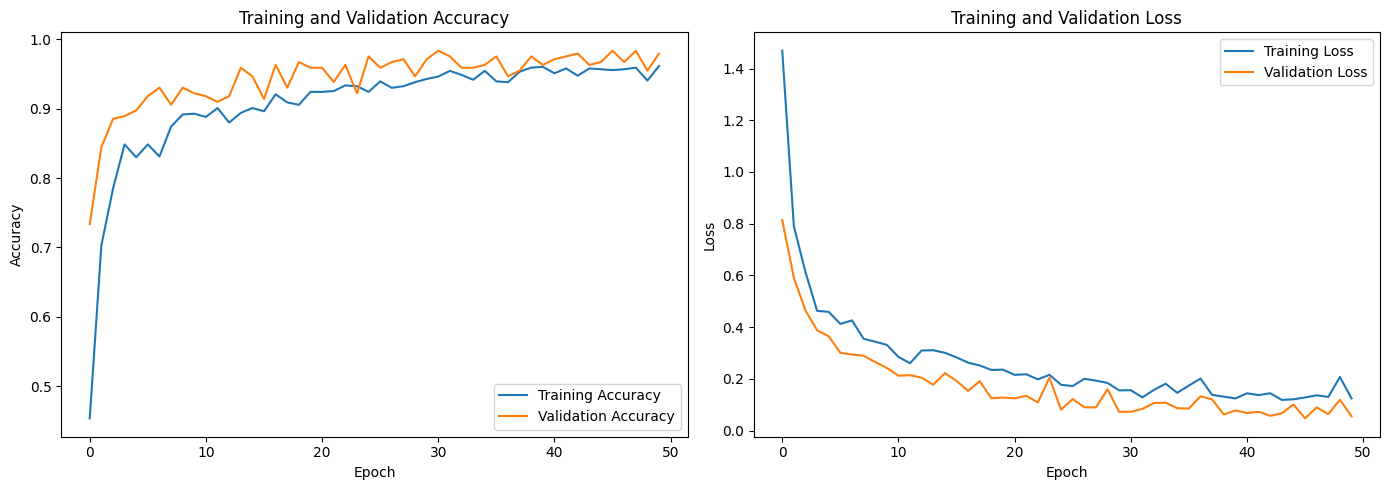

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


<Figure size 800x600 with 0 Axes>

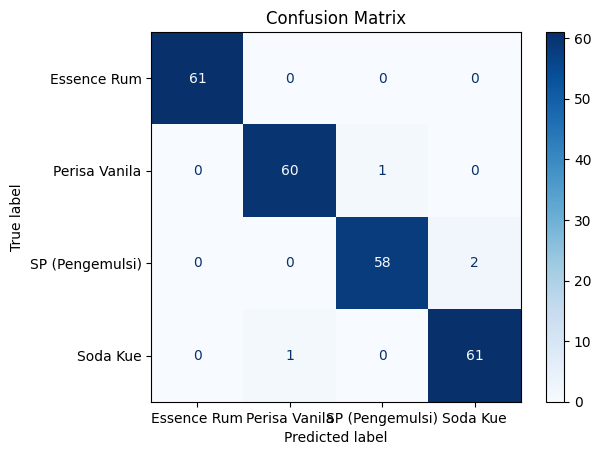

Classification Report:
                 precision    recall  f1-score   support

    Essence Rum       1.00      1.00      1.00        61
  Perisa Vanila       0.98      0.98      0.98        61
SP (Pengemulsi)       0.98      0.97      0.97        60
       Soda Kue       0.97      0.98      0.98        62

       accuracy                           0.98       244
      macro avg       0.98      0.98      0.98       244
   weighted avg       0.98      0.98      0.98       244



In [14]:
# ===== VISUALISASI GRAFIK AKURASI & LOSS =====
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Ambil data dari training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Plot akurasi dan loss
plt.figure(figsize=(14, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# ===== CONFUSION MATRIX & CLASSIFICATION REPORT =====

# Pastikan val_gen tidak shuffle untuk valid label urutan sama
y_true = val_gen.classes

# Prediksi
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Nama kelas
class_names = list(val_gen.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Saving IMG_20250415_160719.jpg to IMG_20250415_160719.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


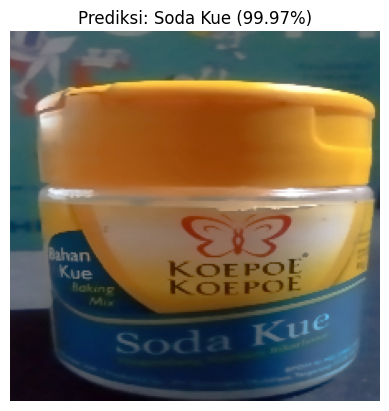

In [22]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# === UPLOAD GAMBAR BARU ===
uploaded = files.upload()

for file_name in uploaded.keys():
    # Load gambar dan preprocessing
    img_path = file_name
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # normalize seperti val_gen
    img_array = np.expand_dims(img_array, axis=0)  # tambah batch dimensi

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    class_name = class_names[predicted_class]
    confidence = np.max(prediction) * 100

    # Tampilkan gambar + prediksi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {class_name} ({confidence:.2f}%)")
    plt.show()
